# LGE - SNU AI Scientist 고급과정 [확률통계 및 통계 방법론]
## 7장: 데이터 사이의 관계와 예측
### TA: 홍현경(hyungyeong81@snu.ac.kr)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. 선형회귀분석(Linear Regression)

- KBO 불펜 투수에 대한 데이터를 이용하여, 지난 시즌 불펜 투수의 성적을 이용한 다음 시즌 연봉을 예측하는 문제를 선형 회귀분석을 이용하여 풀어보자.

- 우선, 데이터 `pitcher_modeling_data.csv`를 불러온 후, 데이터의 형태를 확인한다.

In [ ]:
# 모듈 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot

# 데이터 로드
pitcher_data_file = "/content/drive/MyDrive/pitcher_modeling_data.csv"
data = pd.read_csv(pitcher_data_file, encoding = "UTF-8")
data.head(5)

,year,team,name,ERA,G,W,L,SV,HLD,WPCT,...,K_9,BB_9,K_BB,OBP,SLG,OPS,rank_sv,closer,is_fa,log_salary
0,2020,삼성,임현준,1.78,51,1,1,0,5,0.500,...,6.39,2.49,2.57,0.343,0.359,0.702,3,0,0,9.210340
1,2020,삼성,오승환,2.64,45,3,2,18,2,0.600,...,7.36,2.83,2.60,0.310,0.344,0.654,1,1,0,11.608236
2,2020,삼성,이승현(우),3.48,65,1,2,0,14,0.333,...,8.61,4.14,2.08,0.314,0.442,0.756,3,0,0,9.615805
3,2020,삼성,노건우,4.46,45,2,3,0,10,0.400,...,8.42,7.18,1.17,0.358,0.316,0.674,3,0,0,8.853665
4,2020,삼성,김무신,4.66,61,3,5,0,12,0.375,...,6.36,4.81,1.32,0.374,0.406,0.780,3,0,0,8.987197


- 주어진 데이터에 대한 설명은 다음과 같다.
  - 주어진 데이터는 국내 프로야구팀 소속 비FA 불펜 투수의 2020\~2024 시즌 성적을 이용하여 다음 시즌(2021\~2025시즌)의 연봉을 예측하기 위한 데이터이다.
  - 외국인 선수 및 비FA 다년계약 체결 선수는 제외되었으며, 전체 행은 475개이다.
  - 해당 시즌 출전 경기 중 절반 이상을 선발로 등판하였으면 선발 투수, 그렇지 않은 경우는
불펜 투수로 구분하여 불펜 투수의 데이터만을 추출하였다.
  - 평균자책점(ERA)의 경우 투구 이닝 수가 적은 경우 신뢰하기 어려우므로 해당 시즌 20이닝 이상 투구한 선수들만을 추출하였다.
| 변수명 | 자료형 | 설명 | 비고 |
|------|------|------|------|
| year | 정수형 (int) | 연도 (= KBO 리그 시즌) | 2020 시즌부터 2024 시즌 정보 포함 |
| team | 문자열 (chr) | 선수의 소속 팀 | KBO 소속 10개 구단 중 하나: LG / 한화 / 롯데 / KT / SSG(2020시즌 SK) / 삼성 / KIA / NC / 두산 / 키움 |
| name | 문자열 (chr) | 선수의 이름 | - |
| G | 정수형 (int) | 해당 시즌 출전 경기 수 | - |
| ERA | 실수형 (dbl) | 해당 시즌 평균자책점 | - |
| IP | 실수형 (dbl) | 해당 시즌 이닝 수 | - |
| SO | 정수형 (int) | 해당 시즌 삼진 수 | - |
| BB | 정수형 (int) | 해당 시즌 볼넷 수 | - |
| closer | 범주형 (fctr) | 해당 시즌 마무리 투수 여부 | 해당 시즌 각 팀에서 세이브 수 기준 상위 2위 이내(동일 순위 포함)에 해당하며 시즌 세이브 수가 2회 이상이면 마무리 투수(1), 그렇지 않으면 중간 계투(0)로 분류 |
| salary | 정수형 (int) | 다음 시즌 계약 연봉 | 단위: 만 원 |
| log_salary | 실수형 (dbl) | 로그 변환된 다음 시즌 계약 연봉 | $\log_e x$ 이용 |





- 마무리 투수 여부를 나타내는 범주형 변수인 `closer`가 범주형 변수로 올바르게 인식될 수 있도록 형 변환을 진행한다.

In [ ]:
data['closer'] = data['closer'].astype('object')

- `해당 시즌 출전 경기 수`, `해당 시즌 평균자책점`을 설명변수로 이용하여, `로그 변환된 다음 시즌 계약 연봉`을 예측해보자.
- 우선, 변수간의 관계를 확인하기 위해 주어진 데이터에서 `log_salary`, `G`, `ERA` 변수만을 뽑아 상관계수 행렬을 시각화하자.

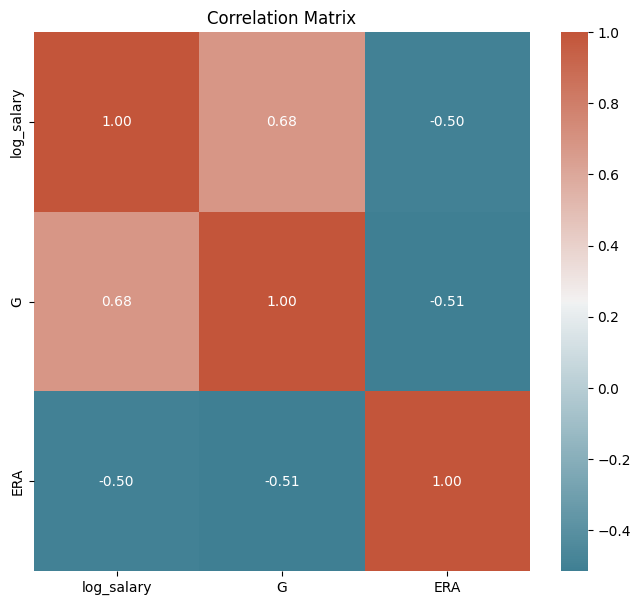

In [ ]:
selected_cols = ['log_salary', 'G', 'ERA']
cor_mat = data[selected_cols].corr()

plt.figure(figsize = (8, 7))
sns.heatmap(cor_mat, annot = True, fmt = ".2f", cmap = sns.diverging_palette(220, 20, as_cmap = True))
plt.title("Correlation Matrix")
plt.show()

- 변수간의 상관관계를 시각적으로 확인하기 위해, 각 설명변수와 반응변수간의 산점도를 시각화해보자.

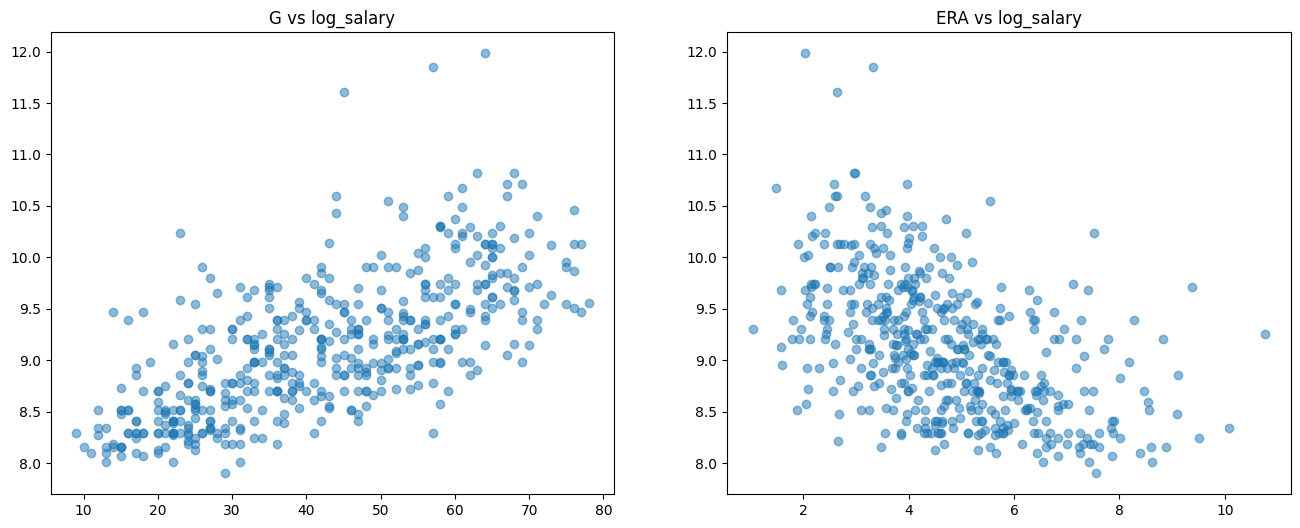

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(data = data, x = "G", y = "log_salary", alpha = 0.5)
axes[0].set_title("G vs log_salary")

axes[1].scatter(data = data, x = "ERA", y = "log_salary", alpha = 0.5)
axes[1].set_title("ERA vs log_salary")

plt.show()

## 1.1 수치형 변수만을 이용한 선형회귀모형의 적합

- Python에서 선형회귀모형을 적합하고 적합 결과를 확인하는 경우 `statsmodels.formula.api`모듈의 `ols()`를 이용한다. 함수 호출 시 전달해야 하는 인자는 다음과 같다.
  - formula: 적합할 회귀모형의 형태를 나타낸다. `반응변수` $\sim$ `설명변수_1` + $\cdots$ + `설명변수_p`의 형태와 같이 반응변수와 설명변수는 ~로 연결하고, 설명변수끼리는 +로 연결한다.
  - data: 사용할 데이터를 명시한다. 앞의 formula에서 명시된 변수들이 인자로 전달되는 데이터에 모두 포함되어 있어야 한다.

- `ols()`를 이용해 선형회귀모형을 선언하고 `fit()`을 통해 모형 적합을 완료한 후, `summary()`를 이용하여 회귀모형 적합 결과를 확인할 수 있다.

- `summary()`의 결과를 통해 개별 회귀계수 추정치와 이에 대한 t-검정 결과는 물론 전체 회귀모형의 유의성에 대한 F-검정 결과, 결정계수($R^2$)와 수정된 결정계수(adjusted $R^2$)를 모두 확인할 수 있다.

- 이제 수치형 변수인 `G`와 `ERA`만을 이용해서 `log_salary`를 반응변수로 하는 선형 회귀모형을 적합해보자.

- 회귀모형을 적합한 후에는 추정된 회귀계수를 확인하고, 모형의 유의성과 개별 회귀계수의 유의성에 대한 검정 결과를 확인해보자.

- 모형의 설명력을 확인하기 위해 결정계수 값과 수정된 결정계수 값을 함께 확인해보자.

In [ ]:
# 다중선형회귀 모형의 형태 선언
formula_numeric = "log_salary ~ G + ERA"

# 다중선형회귀모형 적합
numeric_model = smf.ols(formula=formula_numeric, data=data).fit()

# 다중선형회귀모형 적합 결과 확인
print(numeric_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     232.6
Date:                Thu, 01 Jan 2026   Prob (F-statistic):           2.83e-71
Time:                        23:40:36   Log-Likelihood:                -319.68
No. Observations:                 481   AIC:                             645.4
Df Residuals:                     478   BIC:                             657.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5401      0.119     72.029      0.0

- 반응변수($Y$)를 로그 변환된 다음시즌 연봉이라고 하면, 적합된 회귀식은 다음과 같이 나타낼 수 있다.  
$$
\hat{Y} = 8.5401 + 0.0228 \times G - 0.0793 \times ERA
$$

- 이는 다른 설명변수들이 고정되어 있을 때, 출전 경기 수 G가 1경기 증가하면 로그 변환된 연봉은 약 $0.0228$만큼 증가하고, 평균자책점 ERA가 1점 증가하면 로그 변환된 연봉은 $0.0793$만큼 감소함을 의미한다.

- 유의수준 5% 하에서, F 검정통계량의 값은 $232.6$이고, 이때의 유의확률은 $0.05$ 미만이므로 적합한 선형회귀모형은 유의하다.

- 유의수준 5% 하에서, 개별회귀계수에 대한 t 검정 시 유의확률이 모두 $0.05$ 미만이므로 개별 회귀계수는 모두 유의하다.

- 주어진 모형의 결정계수($R^2$)는 0.493, 수정된 결정계수(adjusted $R^2$)는 0.491이다. 이는 설명변수들이 전체 변동의 약 49%를 설명함을 의미한다.

## 1.2 잔차분석

- 이제 적합한 회귀 모형에 대한 회귀진단 그래프를 시각화하고, 회귀모형의 가정을 만족하는지 확인해보자.

- 이 예제에서는 Residuals vs Fitted Values Plot과 normal Q-Q plot을 시각화한다.

- 이전 단계에서 적합한 `numeric_model`에 `fittedvalues`, `resid` 메서드를 적용하면 추정치와 잔차를 추출할 수 있다.

In [ ]:
# fitted values and residuals
fitted_vals = numeric_model.fittedvalues
residuals = numeric_model.resid

- 잔차와 예측값의 관계를 시각화하여 선형성 및 등분산성 가정을 확인할 수 있다.  
- `sns.residplot()`을 사용하여 잔차 패턴이 특정 구조 없이 고르게 분포하는지 판단할 수 있다.  
- 수평선(`y = 0`)을 기준으로 잔차들이 일정하게 퍼져 있다면 모형의 적합이 적절하다고 볼 수 있다.

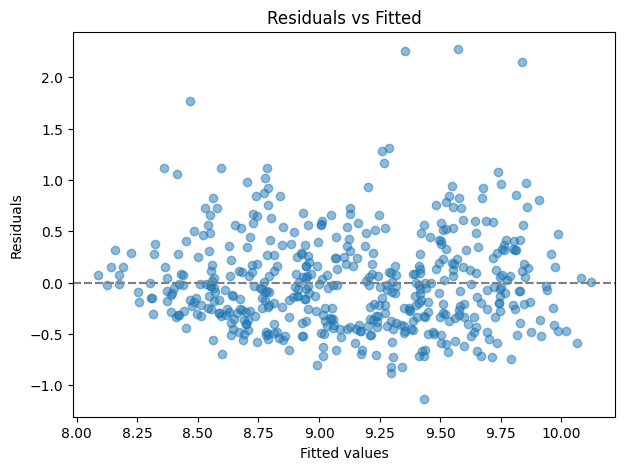

In [ ]:
# Residuals vs Fitted Values Plot
plt.figure(figsize=(7, 5))
sns.residplot(x=fitted_vals, y = residuals, scatter_kws = {"alpha": 0.5})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(0, color = "gray", linestyle='--')
plt.show()

- Q-Q plot을 통해 잔차가 정규분포를 따르는지 시각적으로 확인한다.
- `sm.qqplot()` 함수를 사용하며, `line = '45'` 옵션을 통해 기준선을 함께 표시할 수 있다.  
- `fit = True`를 설정하면 정규분포의 위치와 척도를 데이터에 맞춰 자동 조정한다.

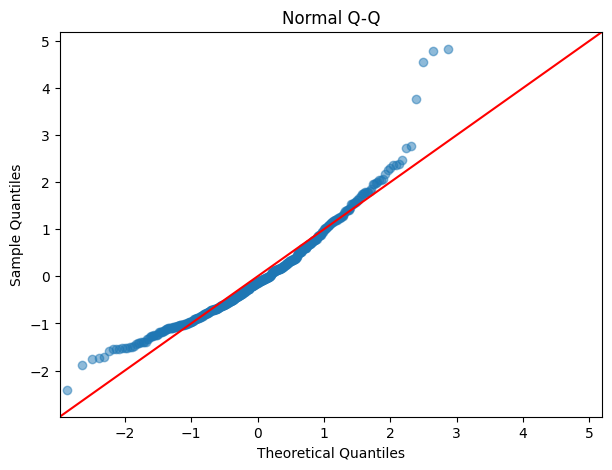

In [ ]:
# Normal Q-Q plot
fig, ax = plt.subplots(figsize=(7, 5))
qqplot(residuals, line='45', fit = True, ax = ax, alpha = 0.5)
ax.set_title("Normal Q-Q")
plt.show()

## 1.3 범주형 설명변수를 이용한 선형회귀모형의 적합


- 이번에는 마무리 투수 여부를 나타내는 범주형 변수인 `closer`를 설명변수로 이용하여 `log_salary`를 반응변수로 하는 다중선형회귀모형을 적합한다.

- 해석의 편의를 위해 이번 실습에서는 하나의 연속형 설명변수만을 고려하여 수치형 변수 `ERA`에 대해 모형을 적합한다.

- `closer`와 `ERA` 변수를 이용하여 다음과 같이 다중선형회귀모형을 적합할 수 있다.

- 연속형 설명 변수만을 이용했을 때와 마찬가지로 `ols()`함수를 이용해 `"log_salary ~ ERA + closer"` 형식으로 모형을 정의하고, `fit()`을 통해 회귀계수를 추정할 수 있다.

In [ ]:
factor_fit1 = smf.ols("log_salary ~ ERA + closer", data = data).fit()
print(factor_fit1.summary())

                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     159.5
Date:                Thu, 01 Jan 2026   Prob (F-statistic):           8.73e-54
Time:                        23:40:38   Log-Likelihood:                -360.21
No. Observations:                 481   AIC:                             726.4
Df Residuals:                     478   BIC:                             738.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.6703      0.078    123.677      

- 데이터로 적합한 회귀직선은 다음과 같다.

  $$
  \hat{Y} = 9.6703 - 0.1401 \times ERA + 0.7617 \times closer
  $$

- 이 때, closer = 1일 때의 회귀직선은

  $$
  \hat{Y} = (9.6703 + 0.7617) - 0.1401 \times ERA.
  $$

- closer = 0일 때의 회귀직선은

  $$
  \hat{Y} = 9.6703 - 0.1401 \times ERA.
  $$

- 적합한 모형을 시각화한 결과는 다음과 같다.

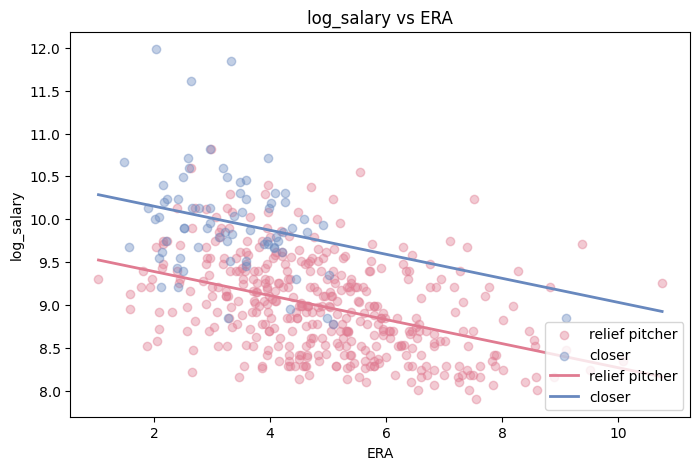

In [ ]:
# 설명변수의 range에 해당하는 x값들을 구하기, 길이 100
var_range = np.linspace(data["ERA"].min(), data["ERA"].max(), 100)

# fitted value를 담아줄 데이터프레임 만들기
pred_df1 = pd.concat([
    pd.DataFrame({"ERA": var_range, "closer": 0}),
    pd.DataFrame({"ERA": var_range, "closer": 1})
], ignore_index=True)

# fitted value를 데이터프레임에 추가하기
X_pred1 = pd.get_dummies(pred_df1, drop_first=True)
pred_df1["log_salary"] = factor_fit1.predict(X_pred1)

plt.figure(figsize = (8, 5))

for label, color in zip([0, 1], ["#E07B91", "#6888BE"]):
    subset = data[data["closer"] == label]
    plt.scatter(subset["ERA"], subset["log_salary"], alpha = 0.4, color = color,
                    label = "relief pitcher" if label == 0 else "closer")

for label, color in zip([0, 1], ["#E07B91", "#6888BE"]):
    subset = pred_df1[pred_df1["closer"] == label]
    plt.plot(subset["ERA"], subset["log_salary"], color = color, linewidth = 2,
                 label = "relief pitcher" if label == 0 else "closer")

plt.title("log_salary vs ERA")
plt.xlabel("ERA")
plt.ylabel("log_salary")
plt.legend(loc = "lower right")
plt.show()

## 1.4 교호작용을 포함한 선형회귀모형의 적합

- 이번에는 교호작용을 고려한 다중선형회귀모형을 적합한다.

- 교호작용을 고려하는 경우, 교호작용을 고려할 설명변수 사이를 ~가 아닌 *로 연결함으로써 모형을 적합할 수 있다.

- `ERA`와 `closer` 변수의 교호작용을 고려하는 경우 `log_salary ~ ERA * closer`와 같이 formula 인자를 명시하면 된다.

- 이 때, `log_salary ~ ERA + closer + ERA * closer`와 같이 표현하지 않고 `log_salary ~ ERA * closer`만으로 formula를 전달해도 개별 설명변수에 대한 항은 자동으로 고려된다.

In [ ]:
factor_fit2 = smf.ols("log_salary ~ ERA * closer", data = data).fit()
print(factor_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     106.5
Date:                Thu, 01 Jan 2026   Prob (F-statistic):           8.49e-53
Time:                        23:40:39   Log-Likelihood:                -359.82
No. Observations:                 481   AIC:                             727.6
Df Residuals:                     477   BIC:                             744.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.6512      0.081    1

- 데이터로 적합한 회귀직선은 다음과 같다.

  $$
  \hat{Y} = 9.6512 - 0.1363 \times ERA + 0.9312 \times closer - 0.0488 \times (ERA \times closer)
  $$

- 이 때, closer = 1일 때의 회귀직선은

  $$
  \hat{Y} = (9.6512 + 0.9312) - (0.1363 + 0.0488) \times ERA.
  $$

- closer = 0일 때의 회귀직선은

  $$
  \hat{Y} = 9.6512 - 0.1363 \times ERA.
  $$

- 단, 회귀모형 적합 결과 유의수준 5% 하에서 교호작용에 대한 유의확률이 0.05보다 크게 나타나 교호작용이 유의하지 않음에 주의한다.

- 적합한 모형을 시각화한 결과는 다음과 같다.

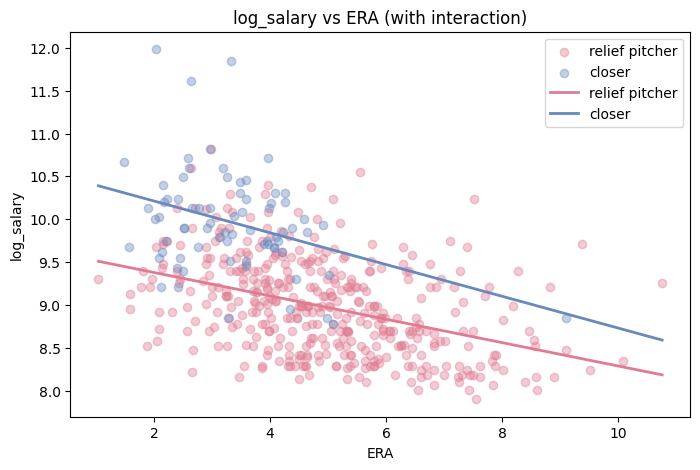

In [ ]:
# 설명변수의 range에 해당하는 x값들을 구하기, 길이 100
var_range = np.linspace(data["ERA"].min(), data["ERA"].max(), 100)

# fitted value를 담아줄 데이터프레임 만들기
pred_df2 = pd.concat([
    pd.DataFrame({"ERA": var_range, "closer": 0}),
    pd.DataFrame({"ERA": var_range, "closer": 1})
], ignore_index = True)

# fitted value를 데이터프레임에 추가하기
X_pred2 = pd.get_dummies(pred_df2, drop_first = True)
pred_df2["log_salary"] = factor_fit2.predict(X_pred2)

plt.figure(figsize = (8, 5))

for label, color in zip([0, 1], ["#E07B91", "#6888BE"]):
    subset = data[data["closer"] == label]
    plt.scatter(subset["ERA"], subset["log_salary"], alpha = 0.4, color = color,
                    label = "relief pitcher" if label == 0 else "closer")

for label, color in zip([0, 1], ["#E07B91", "#6888BE"]):
    subset = pred_df2[pred_df2["closer"] == label]
    plt.plot(subset["ERA"], subset["log_salary"], color = color, linewidth = 2,
                 label = "relief pitcher" if label == 0 else "closer")

plt.title("log_salary vs ERA (with interaction)")
plt.xlabel("ERA")
plt.ylabel("log_salary")
plt.legend(loc = "upper right")
plt.show()

## 1.5 베이지안 회귀분석

- 이번에는 `log_salary ~ G + ERA` 선형회귀모형을 베이지안 방식으로 적합해보자.

- 회귀계수 $\beta$와 표준편차 $\sigma$에 사전분포(prior distribution)를 가정한 뒤, 관측된 데이터 $(Y, X)$가 주어졌을 때의 사후분포(posterior distribution) 를 통해 $\beta, \sigma$를 추론한다.

- 관측치가 $n$개일 때, 다음과 같은 표현을 가정하자.
  - 반응변수 벡터: $Y = (Y_1,\dots,Y_n)^\top$ (이 때, $Y_i = (log\_salary)_i$)
  - 설명변수 행렬: $X = [\mathbf{1},\; G,\; ERA]$
  - 회귀계수 벡터: $\beta = (\beta_0,\beta_G,\beta_{ERA})^\top$

- 선형회귀모형은 아래와 같이 나타낼 수 있다.
$$
Y = X\beta + \varepsilon,\qquad \varepsilon \sim N(0,\sigma^2 I_n)
$$

- 따라서,
$$
Y \mid \beta,\sigma^2,X \sim N(X\beta,\sigma^2 I_n).
$$

- 회귀계수의 사전분포를 가정하자.
  - 각 계수에 대해 독립적으로 다음과 같은 공통의 prior를 부여하자.
  $$
  \beta_j \sim N(0,\tau^2),\quad \tau=100
  $$
  - 그러면, $\beta \sim N(0, \tau^2 I)$로 나타낼 수 있다.

- 이번에는 $\sigma$의 사전분포를 가정하자.
$$
\sigma \sim \mathrm{IGamma}(\alpha, \beta),\quad \alpha=2,\; \beta=0.5.
$$

- 그러면, 베이즈 정리에 의해 결합 사후분포는
$$
\pi(\beta,\sigma \mid Y,X)
\propto
\sigma^{-(n+a+1)}
\exp\!\left(
-\frac{1}{2\sigma^2}(Y-X\beta)^\top(Y-X\beta)
-\frac{1}{2\tau^2}\beta^\top\beta
-\frac{b}{\sigma}
\right).
$$

- 베이지안 선형회귀에서는 보통
$$
\beta \mid \sigma^2 \sim N(\cdot), \qquad
\sigma^2 \sim \mathrm{Inverse\text{-}Gamma}(a,b)
$$
와 같은 공액 사전분포(conjugate prior)를 가정한다.

- 그러나 이 예제에서는 $\sigma^2$가 아닌 표준편차 $\sigma$ 자체에 대해 prior를 부여한다.  
$$
\sigma \sim \mathrm{Inverse\text{-}Gamma}(a,b)
$$

- 이와 같이 $\sigma$에 직접 inverse-gamma prior를 두면,
$
\pi(\sigma \mid Y,X)
$
는 더 이상 inverse-gamma 분포 형태로 정리되지 않는다.

- 따라서 이 경우에는 사후분포에 대하여 MCMC 방법을 이용한 수치적 추론이 필요하다.

- 본 예시에서는 베이지안 회귀분석 라이브러리인 Bambi를 사용하며,Bambi는 내부적으로 PyMC를 기반으로 하여 HMC(Hamiltonian Monte Carlo), 그중에서도 NUTS(No-U-Turn Sampler) 알고리즘을 이용해 사후분포에서 표본을 생성한다.

- 따라서 본 예제에서는
$
\pi(\beta,\sigma \mid Y,X)
$
로부터 HMC, NUTS를 통해 사후표본을 추출하고, 이를 이용해 회귀계수 $\beta$와 오차에 대한 표준편차 $\sigma$에 대한 사후평균(posterior mean), 그리고 사후분포에서 95%의 확률을 갖는 구간 중 가장 길이가 짧은 구간인 HDI(Highest Density Interval)등의 베이지안 추론 결과를 얻는다.

In [ ]:
# !pip install bambi arviz
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

# beta ~ Normal(0, sd = tau_coef)
tau_coef = 100.0

# sigma ~ InverseGamma(alpha = 2, beta = 0.5) (주의: sigma^2가 아닌 sigma 자체의 prior)
alpha_ig = 2.0
beta_ig  = 0.5

# prior 지정
priors = {
    "common":    bmb.Prior("Normal", mu = 0, sigma = tau_coef), # 설명변수 계수의 prior
    "Intercept": bmb.Prior("Normal", mu = 0, sigma = tau_coef), # 절편의 prior
    "sigma":     bmb.Prior("InverseGamma", alpha = alpha_ig, beta = beta_ig), # sigma의 prior
}

# 모델 적합
model = bmb.Model("log_salary ~ G + ERA", data = data, family = "gaussian", priors = priors)
idata = model.fit(draws = 2000, tune = 1000, chains = 4, target_accept = 0.9, random_seed = 2026)

# 결과 요약
print(az.summary(idata, var_names = ["Intercept", "G", "ERA", "sigma"], hdi_prob = 0.95))

Output()

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  8.540  0.118     8.309      8.771      0.002    0.001    6002.0   
G          0.023  0.002     0.020      0.026      0.000    0.000    7102.0   
ERA       -0.079  0.015    -0.108     -0.050      0.000    0.000    6420.0   
sigma      0.472  0.015     0.443      0.503      0.000    0.000    7385.0   

           ess_tail  r_hat  
Intercept    5393.0    1.0  
G            6290.0    1.0  
ERA          5524.0    1.0  
sigma        5988.0    1.0  


- 이제, 각 파라미터의 사후분포에서 표본이 안정적으로 생성되었는지를 확인하기 위해 trace plot을 확인하자.

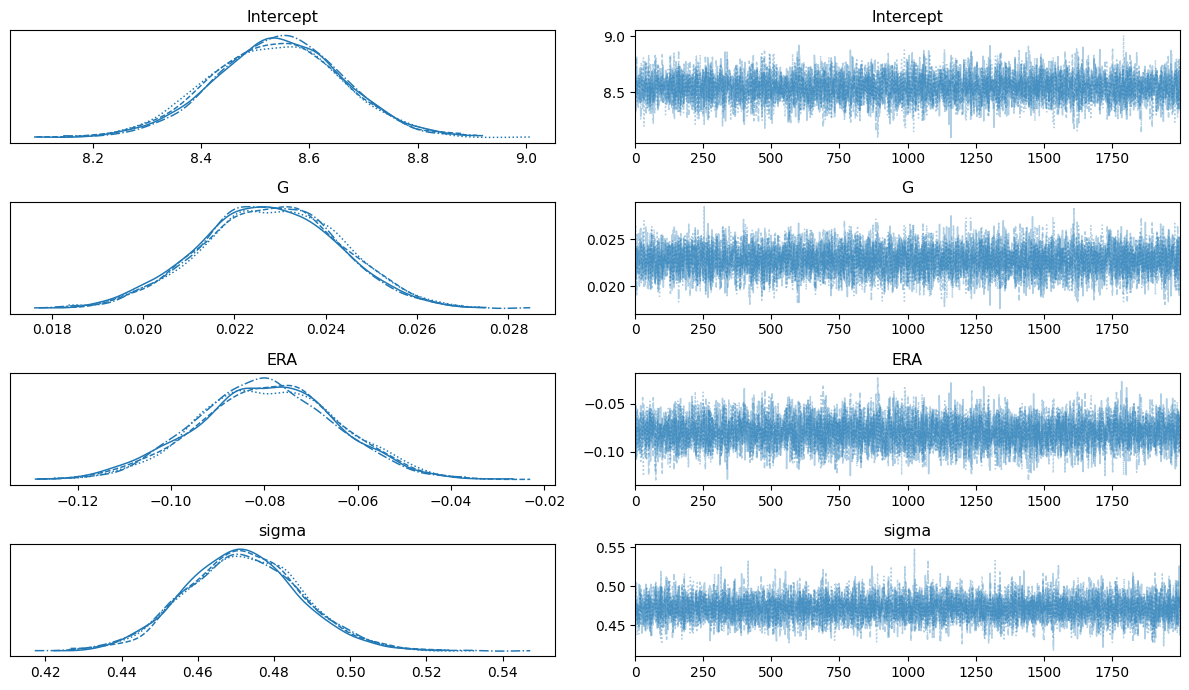

In [ ]:
# trace plot
axes = az.plot_trace(idata, var_names=["Intercept", "G", "ERA", "sigma"], figsize = (12, 7))
plt.tight_layout()
plt.show()

- 각 파라미터의 사후분포와 함께 `hdi_prob = 0.95`를 통해 사후분포 확률의 95%에 대한 HDI를 확인함으로써, 추정값의 불확실성을 파악해보자.

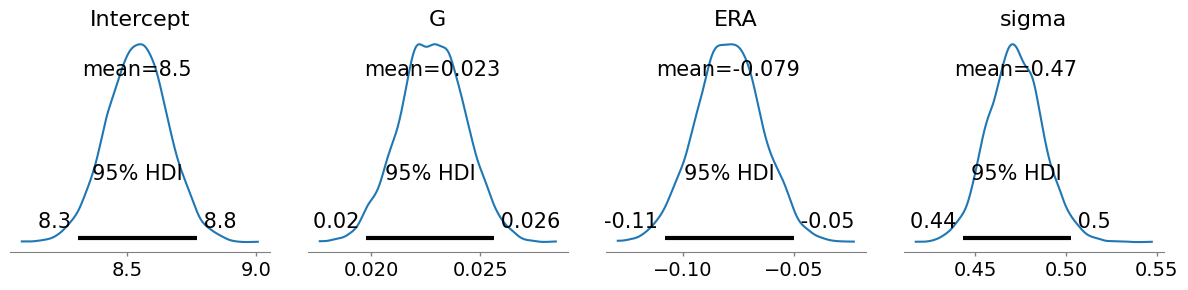

In [ ]:
# posterior 분포 시각화
axes = az.plot_posterior(idata, var_names=["Intercept", "G", "ERA", "sigma"], hdi_prob = 0.95, figsize = (12, 3))
plt.tight_layout()
plt.show()

## 1.6 Model Selection
- 이번에는 `G`, `ERA`, `IP`, `SO`, `BB`, `closer`를 설명변수로, `log_salary`를 반응변수로 하여 선형회귀모형을 적합하는 상황을 고려하자.

- 일반적으로 설명변수의 수가 많다고 해서 항상 더 좋은 모형이 되는 것은 아니다.

- 따라서 이 예제에서는 가능한 후보 모형들 중 가장 좋은 모형을 효과적으로 찾기 위해, 모형 선택의 기준이 되는 지표인 AIC, BIC 그리고 Mallow's Cp를 이용한 모형 선택 과정을 직접 코드로 구현해 보자.

- 각각의 지표에 대하여, 다음과 같은 3가지 방법을 고려 가능하다.
  - 전진 선택법(forward selection): 변수가 없는 모형에서 시작하여, 모형 선택 기준 지표(AIC, BIC, Mallow's Cp)를 가장 개선시키는 변수를 선택해나가는 방법
  - 후진 소거법(backward selection): 모든 변수가 포함된 모형에서 시작하여, 변수를 제거했을 때 모형 선택 기준 지표(AIC, BIC, Mallow's Cp)이 가장 개선되는 변수를 제거해나가는 방법
  - 전진 후진 혼합법(stepwise selection): 변수가 없는 모형에서 시작하여, 변수를 추가하고(전진 선택), 기존 모형의 변수를 제거(후진 소거)하는 과정을 반복하는 방법

- 우선, Mallow's Cp 계산을 위해, 모든 변수가 포함된 모형에서의 $\hat \sigma^2_F$를 계산하자.

In [ ]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# 설명변수, 반응변수 구성
df = data.copy()
y = df["log_salary"].values
X = df[["G", "ERA", "IP", "SO", "BB", "closer"]].values
n, p_total = X.shape

# full model 적합 (모든 설명변수 이용)
full_est = LinearRegression()
full_est.fit(X, y)

y_full_pred = full_est.predict(X)
resid_full = y - y_full_pred
rss_full = np.sum(resid_full**2)

# 파라미터 개수: p_total + intercept 1개
k_full = p_total + 1
sigma2_full = rss_full / (n - k_full)

- 설명변수의 수를 $k$라고 할 때, AIC, BIC, Mallow's Cp의 식은 다음과 같다.
  - $AIC = n \times \log(RSS/n) + 2k$
  - $BIC = n \times \log(RSS/n) + k \times \log(n)$
  - $Mallow's \ C_p = RSS / \hat \sigma^2_F - (n - 2k)$
- 이 식을 이용하여, AIC, BIC, Mallow's Cp를 계산 함수를 정의하자.

In [ ]:
# AIC, BIC, Mallow's C_p 계산
def aic_scorer(estimator, X_sub, y_sub):
    n_sub = X_sub.shape[0]
    k_sub = X_sub.shape[1] + 1

    y_pred = estimator.predict(X_sub)
    resid = y_sub - y_pred
    rss = np.sum(resid**2)

    aic = n_sub * np.log(rss / n_sub) + 2 * k_sub
    # 반환값은 -AIC (클수록 좋게 만들기 위해)
    return -aic


def bic_scorer(estimator, X_sub, y_sub):
    n_sub = X_sub.shape[0]
    k_sub = X_sub.shape[1] + 1

    y_pred = estimator.predict(X_sub)
    resid = y_sub - y_pred
    rss = np.sum(resid**2)

    bic = n_sub * np.log(rss / n_sub) + k_sub * np.log(n_sub)
    # 반환값은 -BIC (클수록 좋게 만들기 위해)
    return -bic


def cp_scorer(estimator, X_sub, y_sub):
    n_sub = X_sub.shape[0]
    k_sub = X_sub.shape[1] + 1

    y_pred = estimator.predict(X_sub)
    resid = y_sub - y_pred
    rss = np.sum(resid**2)

    cp = rss / sigma2_full - (n_sub - 2 * k_sub)
    # 반환값은 -cp (클수록 좋게 만들기 위해)
    return -cp

- 이제 AIC, BIC, 그리고 Mallow's Cp를 모형 선택 기준으로 하여,  
forward, backward, stepwise 방식의 순차적 변수 선택 방법을 각각 적용하자.
- 각 조합에 대해 `SequentialFeatureSelector`를 이용하여 최적의 설명변수 조합을 자동으로 탐색하고, 선택된 변수와 해당 기준에서의 점수를 함께 출력하자.

In [ ]:
# 세 가지 기준을 반복 적용하기 위한 딕셔너리
criterion_scorers = {
    "AIC": aic_scorer,
    "BIC": bic_scorer,
    "Cp": cp_scorer
}

# 서로 다른 변수 선택 탐색 방식을 설정
search_configs = {
    "forward":  dict(forward = True,  floating = False),
    "backward": dict(forward = False, floating = False),
    "stepwise": dict(forward = True,  floating = True)
}


estimator = LinearRegression()
results = {}


# (AIC/BIC/Cp)에 대해 (forward/backward/stepwise) 방식으로 최적의 변수 조합을 자동 탐색
for crit_name, scorer in criterion_scorers.items():
    results[crit_name] = {}
    print(f"\n==================== {crit_name} 기준 ====================")

    for search_name, cfg in search_configs.items():
        sfs = SFS(
            estimator = estimator,
            k_features = "best",
            scoring = scorer,
            cv = 0, # CV 없이 전체 데이터 기준으로 계산
            **cfg
        )

        sfs = sfs.fit(X, y)

        selected_idx = list(sfs.k_feature_idx_)
        selected_names = list(np.array(["G", "ERA", "IP", "SO", "BB", "closer"])[selected_idx])
        best_score = sfs.k_score_ # 정의한 -AIC/-BIC/-Cp의 최댓값

        results[crit_name][search_name] = {
            'indices': selected_idx,
            'names': selected_names,
            'score': best_score,
        }

        print(f"{search_name:>8} 선택 변수: {selected_names},  점수(−{crit_name}) = {best_score:.3f}")


==================== AIC 기준 ====================
 forward 선택 변수: [np.str_('G'), np.str_('ERA'), np.str_('IP'), np.str_('BB'), np.str_('closer')],  점수(−AIC) = 812.427
backward 선택 변수: [np.str_('G'), np.str_('ERA'), np.str_('IP'), np.str_('BB'), np.str_('closer')],  점수(−AIC) = 812.427
stepwise 선택 변수: [np.str_('G'), np.str_('ERA'), np.str_('IP'), np.str_('BB'), np.str_('closer')],  점수(−AIC) = 812.427

==================== BIC 기준 ====================
 forward 선택 변수: [np.str_('G'), np.str_('ERA'), np.str_('IP'), np.str_('BB'), np.str_('closer')],  점수(−BIC) = 787.372
backward 선택 변수: [np.str_('G'), np.str_('ERA'), np.str_('IP'), np.str_('BB'), np.str_('closer')],  점수(−BIC) = 787.372
stepwise 선택 변수: [np.str_('G'), np.str_('ERA'), np.str_('IP'), np.str_('BB'), np.str_('closer')],  점수(−BIC) = 787.372

==================== Cp 기준 ====================
 forward 선택 변수: [np.str_('G'), np.str_('ERA'), np.str_('IP'), np.str_('BB'), np.str_('closer')],  점수(−Cp) = -5.710
backward 선택 변수: [np.str_('G'), np.

# 2. Penalized Regression

- 전통적 선형회귀분석의 경우, 설명변수가 많으면 최소제곱법으로 추정된 회귀계수의 변동성이 커져 예측성능이 감소하는 문제가 발생하기도 한다.

- 이 경우, 일부 회귀계수를 0 또는 0에 가깝게 만들었을 때 예측성능이 향상되기도 한다.

- 이번에는, 일부 회귀계수를 0 또는 0에 가깝게 만들기 위한 penalized regression 방법인 ridge regression, LASSO regression 그리고 Elastic Net 방법을 알아본다.

- 이번 실습에서는 서울시 법정동 단위의 아파트 매매가격과 관련된 지역 특성 정보를 포함한 데이터를 이용한다. 각 변수에 대한 설명은 다음과 같다.

| 변수명 | 설명 |
|--------|------|
| y | 서울시 아파트 매매 제곱미터당 가격 평균(원), 로그변환 |
| avg_apt_age | 평균 아파트 나이(2023년 기준) |
| avg_TF_large | 대단지 아파트 비율 |
| cnt | 아파트 수 |
| rate_big_area_m2 | 대형평수 (85m^2 이상) 비율 |
| pop_50_69 | 50-59세 주민등록연앙인구 |
| rate_buy | 자가비율, 매매, 전세, 월세 중 매매가 차지하는 비율 |
| rate_welfare_recipient | 국민기초생활보장 수급자 비율 (%) |
| avg_D_Sub | 인근 지하철 역까지의 평균 거리(m) |

In [ ]:
url = "/content/drive/MyDrive/apt_data.csv"
data = pd.read_csv(url, encoding = "UTF-8")
data.head(5)

,SGG_nm,SGG_cd,BJD_nm,BJD_eng_nm,BJD_cd,y,avg_apt_age,avg_TF_large,cnt,rate_big_area_m2,pop_50_69,rate_buy,rate_welfare_recipient,avg_D_Sub
0,종로구,11110,사직동,Sajik-dong,11500,16.327688,15.863636,0.0,1,0.450269,217.958333,0.136364,1.276997,374.117323
1,종로구,11110,내수동,Naesu-dong,11800,16.370882,19.240000,0.0,1,0.200000,217.958333,0.178571,1.276997,250.109060
2,종로구,11110,익선동,Ikseon-dong,13300,15.886013,20.444444,0.0,1,0.000000,84.821429,0.329787,12.970904,286.843966
3,종로구,11110,인의동,Inui-dong,15700,16.128513,17.000000,0.0,1,0.483221,84.821429,0.106061,12.970904,282.140316
4,종로구,11110,효제동,Hyoje-dong,16200,16.427947,3.061224,0.0,1,0.000000,318.100000,0.443299,6.327994,616.167132


- 처음 다섯개 열은 주소에 관한 변수로, 관측치들을 구분하는데 사용되므로 분석 대상에서 제외한다.

- 국민기초생활 수급자에 관한 변수 `rate_welfare_recipient` 변수는 백분율로 제시되어 있는데 해석의 통일성을 위해 비율 단위로 바꾼다.

In [ ]:
# 주소 변수 제거 (1~5번째 컬럼)
data = data.iloc[:, 5:]

# 백분율 변수를 비율로 변환
data["rate_welfare_recipient"] = data["rate_welfare_recipient"] / 100

- Ridge, LASSO, Elastic Net을 적용하기 전에 분석에 필요한 설명변수와 반응변수를 구성하고, 설명변수를 표준화하자.
- 표준화는 `StandardScaler`를 이용해 진행한다. 이를 통해 각 변수는 평균 0, 분산 1이 되도록 변환되며, 이를 통해 변수 간 scale 차이를 제거한다.
- Ridge, LASSO, Elastic Net에서는 설명변수의 크기가 서로 다를 경우 패널티의 영향이 변수마다 불균등하게 적용될 수 있기에, 표준화를 통해 모든 설명변수를 동일한 scale로 맞춰준다.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# 설명변수, 반응변수 설정
df = data.copy()

y = df["y"].values
X = df[["avg_apt_age", "avg_TF_large", "cnt", "rate_big_area_m2", "pop_50_69", "rate_buy", "rate_welfare_recipient", "avg_D_Sub"]].values
feature_names = ["avg_apt_age", "avg_TF_large", "cnt", "rate_big_area_m2", "pop_50_69", "rate_buy", "rate_welfare_recipient", "avg_D_Sub"]

# 설명변수 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2.1 Ridge Regression

- Ridge 회귀는 최소제곱법(LSE)에 L2 패널티를 추가한 회귀모형으로, 다음의 목적함수를 최소화한다.
$$
\text{RSS}(\beta) + \lambda \sum_{j=1}^{p} \beta_j^2
$$
- 여기서,
  - $\text{RSS}(\beta) = \sum_{i=1}^n (y_i - x_i^\top \beta)^2$  
  - $\lambda \ge 0$는 패널티의 크기를 조절하는 튜닝 파라미터이다.
  - $\lambda$ 값이 증가하면 추정된 회귀계수는 0에 가까워진다.
  - $\lambda = 0$인 경우 최소제곱추정(LSE)과 동일하다.
- 이는 회귀계수에 약간의 편향(bias)을 허용하는 대신, 분산을 줄여 전체 예측 오차(MSE)를 감소시키는 방법이다.
- Ridge 회귀의 추정치는 다음과 같이 명시적으로 표현된다.
$$
\hat{\beta}_{\text{ridge}}
=
(X^\top X + \lambda I)^{-1} X^\top Y
$$

- Ridge 회귀에서 패널티 파라미터 $\lambda$는 미리 주어져야 하며, 이는 모형의 성능에 직접적인 영향을 미친다.

- $\lambda$가 너무 작으면 정규화 효과가 약해 과적합의 위험이 있고, 너무 크면 계수들이 과도하게 축소되어 모형이 과소적합될 수 있다.

- 일반적으로 적절한 $\lambda$를 선택하기 위해 cross-validation을 사용한다.  

- Cross-validation은 데이터를 여러 개의 부분집합(fold 또는 개별 데이터)으로 나누어, 일부 데이터로 모형을 학습하고 나머지 데이터로 모델의 성능을 평가하는 과정을 반복하는 방법이다.

- 그 중, K-fold cross validation에서는 전체 데이터를 K개의 fold로 나눈 뒤,  
각 fold를 한 번씩 검증용 데이터로 사용하여 예측 오차를 계산하고, 이 K번의 결과를 이용한 평균 예측 오차를 계산한다.

- 또한 LOOCV(Leave-One-Out Cross-Validation)는 전체 데이터 중 한 관측치만을 검증용으로 남기고 나머지 관측치로 모형을 학습하는 과정을 모든 관측치에 대해 반복하여 예측 성능을 평가하는 방법이다.

- 이때 평균 예측 오차를 최소화하는 $\lambda$를 최종 튜닝 파라미터로 선택한다.

- 이러한 과정을 통해 주어진 데이터에 대해 예측 성능이 가장 우수한 $\lambda$ 값을 데이터 기반으로 결정할 수 있다.

[cross-validation 이미치 출처](https://scikit-learn.org/stable/modules/cross_validation.html)

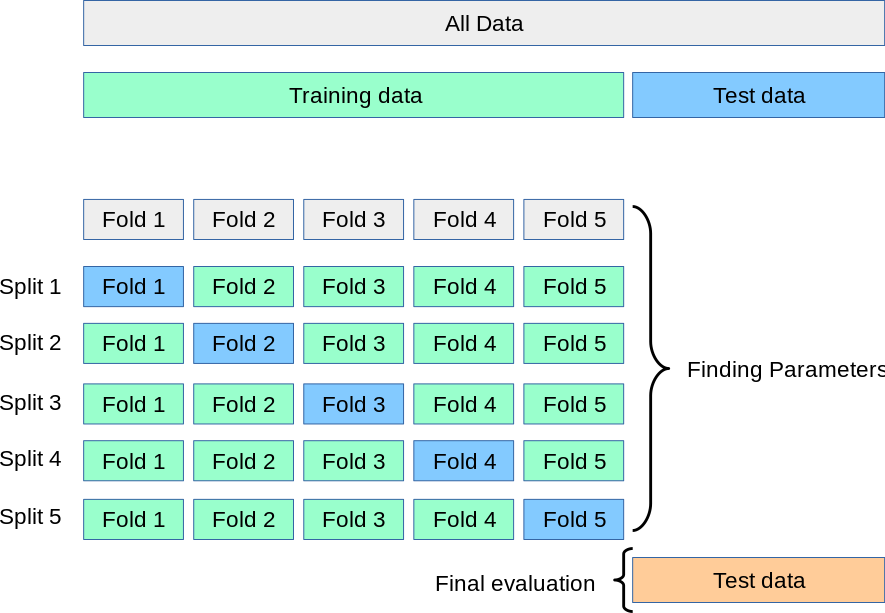

- 이제 Ridge 회귀모형을 적합해보자.

- 먼저 패널티 파라미터의 후보값들을 설정한 뒤, 3-fold cross-validation을 이용해 최적의 파라미터 값을 선택하자.

- `RidgeCV`를 사용하면 주어진 `alpha_grid`에 대해 교차검증을 수행하고, 예측 성능이 가장 우수한 `alpha` 값을 자동으로 결정할 수 있다.

- 그 후, 선택된 `alpha`를 바탕으로 전체 데이터를 이용해 최종 Ridge 회귀모형을 다시 적합하자.

- 선택된 패널티 파라미터 값과 함께, 각 설명변수에 대응하는 회귀계수와 절편을 출력하여 Ridge 회귀모형의 추정 결과를 확인하자.

In [ ]:
# Ridge regression
alpha_grid = np.logspace(2, -3, 100) # 10^-3 ~ 10^2의 그리드 설정
rand_seed = 2026

ridge_cv = RidgeCV(alphas = alpha_grid, cv = 3) # 3-fold CV
ridge_cv.fit(X_scaled, y) # Ridge regression 적합
ridge_final = Ridge(alpha = ridge_cv.alpha_)
ridge_final.fit(X_scaled, y)

print("=== Ridge Regression ===")
print("선택된 alpha:", ridge_cv.alpha_)
print("회귀 계수:")
print(pd.Series(ridge_final.coef_, index=feature_names))
print("절편(beta0):", ridge_final.intercept_)
print()

=== Ridge Regression ===
선택된 alpha: 31.25715849688235
회귀 계수:
avg_apt_age              -0.039904
avg_TF_large              0.048322
cnt                       0.031803
rate_big_area_m2          0.045050
pop_50_69                -0.054842
rate_buy                 -0.127225
rate_welfare_recipient   -0.065708
avg_D_Sub                -0.043812
dtype: float64
절편(beta0): 16.400330457238805



- 이제 $\alpha$의 값에 따라 Ridge 회귀계수가 어떻게 변화하는지를 시각화해보자.  

- 각 $\alpha$ 값에 대해 Ridge 회귀모형을 적합하고, 해당 회귀계수를 저장한 뒤  
$log_{10}(\alpha)$를 x축으로 하여 계수의 변화 경로(Ridge path)를 그려보자.

- 또한, 교차검증을 통해 선택된 최적의 $\alpha$ 값을 수직선으로 표시하여 최종적으로 선택된 $\alpha$가 어떤 영향을 미치는지 함께 확인한다.

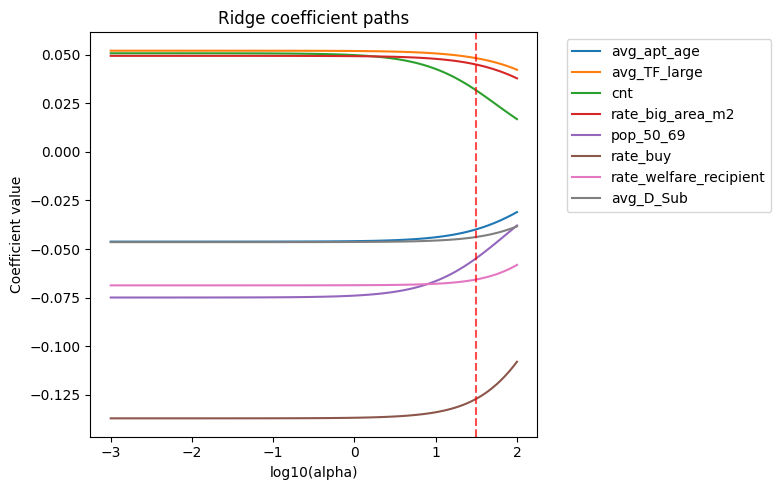

In [ ]:
alphas = alpha_grid
coefs = []

# 각 alpha 값에 대해 Ridge 회귀를 적합하고 회귀계수 저장
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# Ridge coefficient path 시각화
plt.figure(figsize=(8,5))
for j in range(coefs.shape[1]):
    # alpha에 따른 j번째 회귀계수의 변화
    plt.plot(np.log10(alphas), coefs[:, j], label = feature_names[j])

# Cross-validation으로 선택된 alpha 위치 표시
plt.axvline(np.log10(ridge_cv.alpha_), color = "red", linestyle = "--", alpha = 0.7)

plt.xlabel("log10(alpha)")
plt.ylabel("Coefficient value")
plt.title("Ridge coefficient paths")
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.tight_layout()
plt.show()

## 2.2 LASSO regression

- LASSO 회귀는 최소제곱법에 L1 패널티를 추가한 회귀모형으로, 회귀계수를 축소(shrinkage)함과 동시에 변수 선택을 수행할 수 있는 방법이다.

- LASSO 회귀는 다음 목적함수를 최소화한다.
$$
\text{RSS}(\beta) + \lambda \sum_{j=1}^{p} |\beta_j|
$$
- 여기서  
  - $\text{RSS}(\beta) = \sum_{i=1}^{n} (y_i - x_i^\top \beta)^2$
  - $\lambda \ge 0$는 패널티의 크기를 조절하는 튜닝 파라미터이다.
  - $\lambda$가 증가할수록 일부 회귀계수 $\beta_j$는 정확히 0이 되어, 변수 선택(sparsity)이 자동으로 이루어진다.
  - $\lambda = 0$이면 일반적인 최소제곱추정(LSE)과 동일하다.

- 이제 LASSO 회귀모형을 적합해보자.

- 먼저 패널티 파라미터의 후보값들을 설정한 뒤, 3-fold cross-validation을 이용해 최적의 파라미터 값을 선택하자.

- `LassoCV`를 사용하면 주어진 `alpha_grid`에 대해 교차검증을 수행하고, 예측 성능이 가장 우수한 `alpha` 값을 자동으로 결정할 수 있다.

- 그 후, 선택된 `alpha`를 바탕으로 전체 데이터를 이용해 최종 LASSO 회귀모형을 다시 적합하자.

- 선택된 패널티 파라미터 값과 함께, 각 설명변수에 대응하는 회귀계수와 절편을 출력하여 LASSO 회귀모형의 추정 결과를 확인하자.

In [ ]:
# LASSO regression
lasso_cv = LassoCV(alphas = alpha_grid, max_iter = 10000, cv = 3 ,random_state = rand_seed) # 3-fold CV
lasso_cv.fit(X_scaled, y) # LASSO regression 적합
lasso_final = Lasso(alpha=lasso_cv.alpha_, fit_intercept = True)
lasso_final.fit(X_scaled, y)

print("=== Lasso Regression ===")
print("선택된 alpha:", lasso_cv.alpha_)
print("회귀 계수:")
print(pd.Series(lasso_final.coef_, index=feature_names))
print("절편(beta0):", lasso_final.intercept_)
print()

=== Lasso Regression ===
선택된 alpha: 0.0025353644939701114
회귀 계수:
avg_apt_age              -0.042733
avg_TF_large              0.048982
cnt                       0.038797
rate_big_area_m2          0.046971
pop_50_69                -0.063468
rate_buy                 -0.137822
rate_welfare_recipient   -0.067508
avg_D_Sub                -0.044369
dtype: float64
절편(beta0): 16.400330457238805



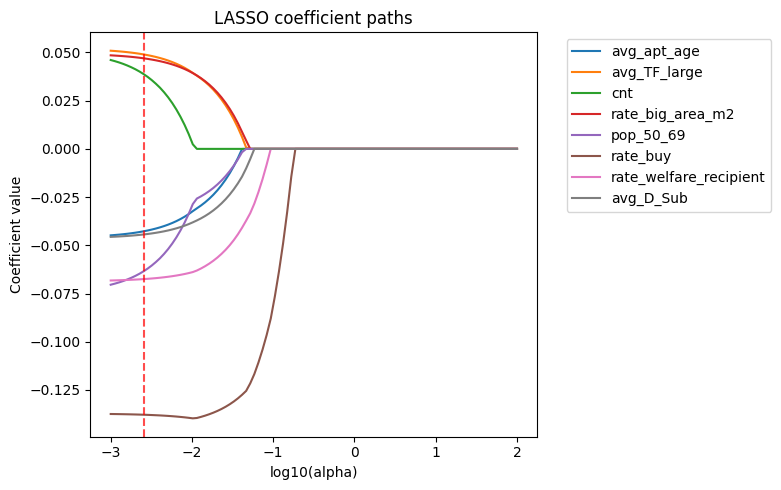

In [ ]:
alphas = alpha_grid
coefs = []

# 각 alpha 값에 대해 LASSO 회귀를 적합하고 회귀계수 저장
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

# LASSO coefficient path 시각화
plt.figure(figsize=(8,5))
for j in range(coefs.shape[1]):
  # alpha에 따른 j번째 회귀계수의 변화
    plt.plot(np.log10(alphas), coefs[:, j], label=feature_names[j])

# Cross-validation으로 선택된 alpha 위치 표시
plt.axvline(np.log10(lasso_cv.alpha_), color="red", linestyle="--", alpha=0.7)

plt.xlabel("log10(alpha)")
plt.ylabel("Coefficient value")
plt.title("LASSO coefficient paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 2.3 The Elastic Net

- Elastic Net은 Ridge 회귀와 LASSO 회귀를 결합한 정규화 회귀모형이다.

- Elastic Net은 다음 목적함수를 최소화한다.
$$
\text{RSS}(\beta)
+ \lambda \left(
\alpha \sum_{j=1}^{p} \beta_j^2
+ (1-\alpha) \sum_{j=1}^{p} |\beta_j|
\right)
$$

- 여기서  
  - $\text{RSS}(\beta) = \sum_{i=1}^{n}(y_i - x_i^\top \beta)^2$,  
  - $\lambda \ge 0$는 전체 패널티의 크기를 조절하는 파라미터이며,  
  - $\alpha \in [0,1]$는 Ridge 패널티와 LASSO 패널티의 비중을 조절하는 파라미터이다.

- 이제 Elastic Net 회귀모형을 적합해보자.

- 먼저 패널티 파라미터 $\lambda$의 후보값들과 함께, Ridge 패널티와 LASSO 패널티의 비중을 조절하는 `l1_ratio` 값들의 후보를 설정하자.  

- 여기서 `l1_ratio = 0`이면 Ridge 회귀, `l1_ratio = 1`이면 LASSO 회귀에 해당하며, 그 사이의 값들은 두 패널티를 혼합한 Elastic Net 모형을 의미한다.

- `ElasticNetCV`를 사용하면 주어진 $\lambda$ 후보(`alpha_grid`)와 `l1_ratio` 후보들에 대해 cross-validation을 수행하여, 성능이 가장 우수한 $\lambda$와 `l1_ratio`의 조합을 자동으로 선택할 수 있다.

- 그 후, 선택된 $\lambda$ 값을 바탕으로 전체 데이터를 이용해 최종 Elastic Net 회귀모형을 다시 적합하자.

- 마지막으로 선택된 $\lambda$와 `l1_ratio` 값, 그리고 각 설명변수에 대응하는 회귀계수와 절편을 출력하여 Elastic Net 회귀모형의 추정 결과를 확인하자.

In [ ]:
# Elastic Net
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9] # l1_ratio: L1 비율 (0 = Ridge, 1 = Lasso)

en_cv = ElasticNetCV(alphas=alpha_grid,l1_ratio=l1_ratios, cv=3, random_state=rand_seed)
en_cv.fit(X_scaled, y)
en_final = ElasticNet(alpha=en_cv.alpha_, fit_intercept=True)
en_final.fit(X_scaled, y)

print("=== Elastic Net ===")
print("선택된 alpha:", en_cv.alpha_)
print("선택된 l1_ratio:", en_cv.l1_ratio_)
print("회귀 계수:")
print(pd.Series(en_final.coef_, index=feature_names))
print("절편(beta0):", en_final.intercept_)

=== Elastic Net ===
선택된 alpha: 0.03678379771828634
선택된 l1_ratio: 0.1
회귀 계수:
avg_apt_age              -0.023157
avg_TF_large              0.030668
cnt                       0.000000
rate_big_area_m2          0.030903
pop_50_69                -0.020052
rate_buy                 -0.134397
rate_welfare_recipient   -0.057424
avg_D_Sub                -0.031585
dtype: float64
절편(beta0): 16.400330457238805


- 이제 Elastic Net에서 선택된 `l1_ratio`를 고정한 상태에서, $\lambda$의 값에 따라 회귀계수가 어떻게 변화하는지를 시각화해보자.

- 먼저 cross-validation을 통해 선택된 최적의 `l1_ratio` 값을 고정한 뒤, 여러 $\lambda$ 값에 대해 Elastic Net을 각각 적합하고 해당 회귀계수를 저장한다.  

- 이 회귀계수들을 이용해 $\log_{10}(\lambda)$를 x축으로 하는 coefficient path를 그린다.

- 또한, 교차검증을 통해 선택된 최적의 $\lambda$ 값을 수직선으로 표시하여, 최종적으로 선택된 패널티 파라미터가 계수 축소와 변수 선택에 어떤 영향을 미치는지 함께 확인한다.

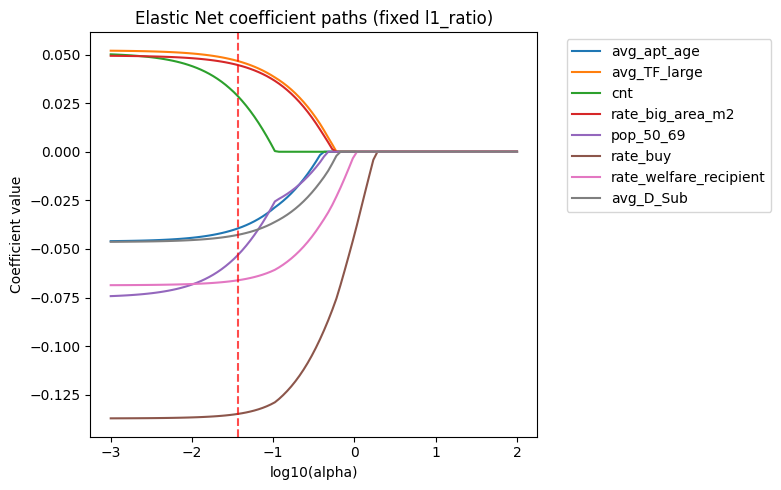

In [ ]:
alphas = alpha_grid
coefs = []

# CV에서 선택된 l1_ratio 고정
l1_ratio_opt = en_cv.l1_ratio_

# 각 alpha 값에 대해 Elastic Net을 적합하고 회귀계수 저장
for a in alphas:
    en = ElasticNet(alpha=a, l1_ratio = l1_ratio_opt, max_iter = 10000)
    en.fit(X_scaled, y)
    coefs.append(en.coef_)

coefs = np.array(coefs)

# Elastic Net coefficient path 시각화
plt.figure(figsize=(8,5))
for j in range(coefs.shape[1]):
    # alpha에 따른 j번째 회귀계수의 변화
    plt.plot(np.log10(alphas), coefs[:, j], label=feature_names[j])

plt.axvline(np.log10(en_cv.alpha_), color="red", linestyle="--", alpha=0.7)
plt.xlabel("log10(alpha)")
plt.ylabel("Coefficient value")
plt.title("Elastic Net coefficient paths (fixed l1_ratio)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#3. Hidden Markov Model

[데이터 출처: UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/271/activities+of+daily+living+adls+recognition+using+binary+sensors)

- 주어진 데이터셋은 스마트 홈 환경에서 수집된 센서 인식(binary) 시계열 데이터와, 이에 대응하는 일상생활 활동(Activities of Daily Living, ADLs)을 수동으로 라벨링한 데이터로 구성되어 있다.

- 이번 실습에서는 센서 이벤트 시퀀스를 관측값 $O_1^T$로 두고, 사용자의 활동(ADL)을 은닉상태 $X_1^T$로 가정한 Hidden Markov Model(HMM)을 학습해 본다.  

- 즉, 센서 이벤트가 시간에 따라 어떻게 나타나는지(출력확률)와 활동이 시간에 따라 어떻게 전이하는지(전이확률)를 데이터로부터 추정하고, 관측된 센서의 시퀀스로부터 가장 그럴듯한 활동 시퀀스를 비터비(Viterbi) 알고리즘으로 복원한다.

- 다음과 같은 순서로 모델링을 진행한다.
  - 관측값 $O_t$ (센서 이벤트)와 은닉상태 $X_t$ (활동)를 정의하고 HMM을 구성한다.
  - Baum–Welch 알고리즘을 이용해 HMM 파라미터 $\lambda=(A,B,\pi)$를 추정한다.
    - $A$: 전이확률행렬, $a_{ij}=P(X_t=j\mid X_{t-1}=i)$  
    - $B$: 출력확률행렬, $b_j(O_t)=P(O_t \mid X_t=j), \ B_{ij} = b_i(O_j)$
    - $\pi$: 초기분포, $\pi_i=P(X_1=i)$
  - 학습된 HMM을 바탕으로 Viterbi 알고리즘을 이용하여 $\hat X_1^T$를 구한다.
  - (평가) 데이터에 포함된 `activity` 라벨은 학습에는 사용하지 않고, 디코딩 결과를 정답과 비교하여 성능을 확인한다.

- 데이터 변수의 구조는 다음과 같다.
| 변수명 | 자료형 | 설명 |
|------|-------|------|
| sens_start | datetime | 센서 이벤트가 발생한 시작 시각 |
| location | categorical | 센서가 설치된 물리적 대상 또는 위치 (예: Bed, Fridge, Toilet) |
| type | categorical | 센서의 종류 (예: PIR, Magnetic, Pressure, Electric, Flush) |
| place | categorical | 센서가 설치된 공간 또는 방 (예: Bedroom, Kitchen, Bathroom) |
| obs | categorical | 센서 이벤트를 표현한 관측값(예: Bed$|$Bedroom) |
| activity | categorical | 일상생활 활동(ADL) (예: Sleeping, Toileting, Showering) |

- 우선, 센서 이벤트 데이터 `house_sensor_data.csv`를 불러오자.

- 그 후, `sens_start` 컬럼이 날짜로 정확히 인식될 수 있도록 datetime 형식으로 변환한 후, 데이터를 시간 순서대로 정렬하자.

In [ ]:
# !pip install hmmlearn
import numpy as np
import pandas as pd
from hmmlearn import hmm
from collections import Counter

# 이 데이터에는 true state인 activity가 주어졌으나, 참고용으로만 사용한다 (일반적으로 true state는 알 수 없다).
data = pd.read_csv("/content/drive/MyDrive/house_sensor_data.csv")
data["sens_start"] = pd.to_datetime(data["sens_start"])
data = data.sort_values("sens_start").reset_index(drop=True)

- 이 모델에서는 관측값 $O_t$가 이산 확률변수에 대응된다.

- 데이터에서, 관측치에 해당하는 센서 이벤트(`obs`)는 문자열 형태이므로, 이를 정수 인덱스로 변환하여 이산형 시퀀스를 구성한다.

- 이에 따라 각 센서 이벤트는 고유한 정수 값에 대응되며, 이렇게 인코딩된 관측 시퀀스는 $(T, 1)$ 형태로 변환되어 HMM의 입력으로 사용된다.

In [ ]:
# observation O_t(discrete) 인코딩
obs_codes, obs_vocab = pd.factorize(data["obs"].astype(str))
X = obs_codes.reshape(-1, 1)
n_obs = len(obs_vocab) # 가능한 관측값의 수 (n_obs개의 카테고리)
T = len(data)
print("T =", T, "| n_obs =", n_obs)

T = 361 | n_obs = 12


- 이제, hidden state(= activity)의 개수가 $N=9$개라고 가정하고, 관측 시퀀스 $O_1^T$만을 이용하여 Hidden Markov Model(HMM)에서 가능도를 최대화하는 파라미터
$$
\lambda = (A, B, \pi)
$$
를 Baum–Welch 알고리즘(EM)을 통해 추정하자.

- 여기에서, $N=9$는 가능한 활동(hidden state)의 개수로, 상태공간의 크기를 의미한다.
- `CategoricalHMM`은 관측값이 이산형인 HMM을 의미한다.

In [ ]:
# hidden state(activity) 수는 9개로 주어짐
N = 9

# 학습: Baum–Welch 이용
model = hmm.CategoricalHMM(n_components = N, n_iter = 300, tol=1e-3, random_state=2026, verbose=False)
model.fit(X)

print("\nLearned parameters:")
print("pi (startprob_) shape:", model.startprob_.shape)
print("A (transmat_) shape:", model.transmat_.shape)
print("B (emissionprob_) shape:", model.emissionprob_.shape)


Learned parameters:
pi (startprob_) shape: (9,)
A (transmat_) shape: (9, 9)
B (emissionprob_) shape: (9, 12)


- HMM 학습이 완료된 후에는, 관측 시퀀스 $O_1^T$가 주어졌을 때 가장 가능도가 높은 은닉상태 시퀀스 $\hat X_1^T$를 추정하는 문제가 남는다. 이를 디코딩(decoding)이라고 하며, 본 실습에서는 Viterbi 알고리즘을 사용한다.

In [ ]:
# 디코딩: Viterbi 이용
logprob, z_hat = model.decode(X, algorithm="viterbi")

In [ ]:
# 결과 dataframe 확인
out = data[["sens_start", "obs", "activity"]].copy()
out["z_hat"] = z_hat
out.head(5)

,sens_start,obs,activity,z_hat
0,2011-11-28 02:27:59,Bed|Bedroom,Sleeping,3
1,2011-11-28 10:21:24,Cabinet|Bathroom,Toileting,8
2,2011-11-28 10:21:44,Basin|Bathroom,Toileting,0
3,2011-11-28 10:23:02,Toilet|Bathroom,Toileting,5
4,2011-11-28 10:25:44,Shower|Bathroom,Showering,8


- 본 실습에서는 HMM 학습 과정에서 활동(activity) 라벨을 사용하지 않았으나, 데이터에 정답 activity가 포함되어 있으므로 참고용으로만 모델의 성능을 평가한다.

- Unsupervised HMM에서 추정된 은닉상태는 정답 라벨과 일대일로 대응되지 않기 때문에 직접적인 비교가 불가능하다. 이를 해결하기 위해 각 은닉상태 $k$에 대해 해당 상태로 예측된 시점들에서 가장 많이 등장한 정답 activity를 대응시킨다.

- 이 정확도는 모델의 절대적인 분류 성능을 의미하지는 않으며, 학습된 HMM이 실제 활동 구조를 어느 정도 포착했는지를 확인하기 위한 참고 지표로 사용된다.

In [ ]:
if "activity" in data.columns:
    true_codes, true_vocab = pd.factorize(data["activity"].astype(str))

    mapping = {}
    for k in np.unique(z_hat):
        cnt = Counter(true_codes[z_hat == k])
        mapping[k] = cnt.most_common(1)[0][0]

    z_mapped = np.array([mapping[k] for k in z_hat], dtype=int)
    acc = (z_mapped == true_codes).mean()
    print("Accuracy(for reference) =", round(acc, 4))

Accuracy(for reference) = 0.5679
